In [8]:
%pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 8.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# 1. Read libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Belgium.csv', header=0, sep=',')
df

,ds,y
0,2015-01,-12.039590
1,2015-02,-11.958950
2,2015-03,-9.755601
3,2015-04,-6.631016
4,2015-05,-5.194805
...,...,...
91,2022-08,49.813010
92,2022-09,60.541520
93,2022-10,63.029320
94,2022-11,36.073860


In [3]:
# print types for each column
df.dtypes

ds     object
y     float64
dtype: object

In [4]:
# convert object into date with yyyy-mm-dd format
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m')
df.tail()

,ds,y
91,2022-08-01,49.81301
92,2022-09-01,60.54152
93,2022-10-01,63.02932
94,2022-11-01,36.07386
95,2022-12-01,32.88156


In [5]:
# print types again
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [6]:
# set 'ds' at index
df.set_index('ds', inplace=True)
df.tail()

,y
ds,
2022-08-01,49.81301
2022-09-01,60.54152
2022-10-01,63.02932
2022-11-01,36.07386
2022-12-01,32.88156


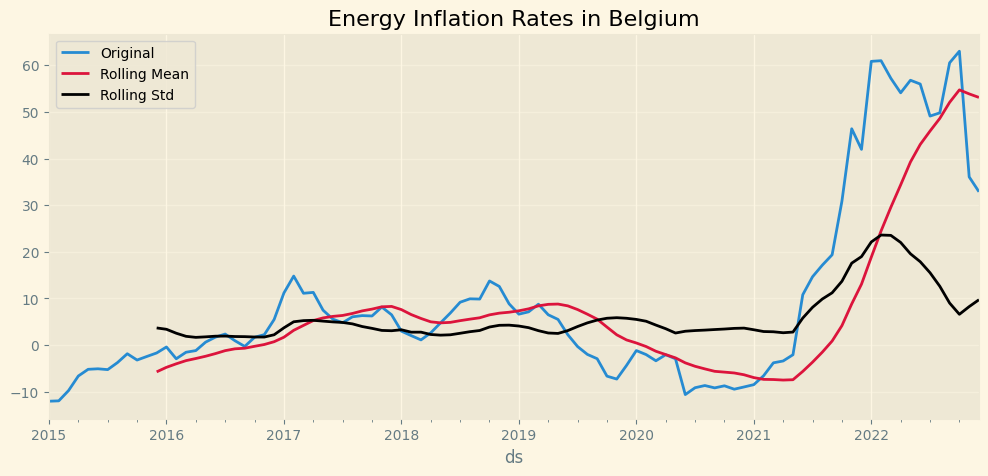

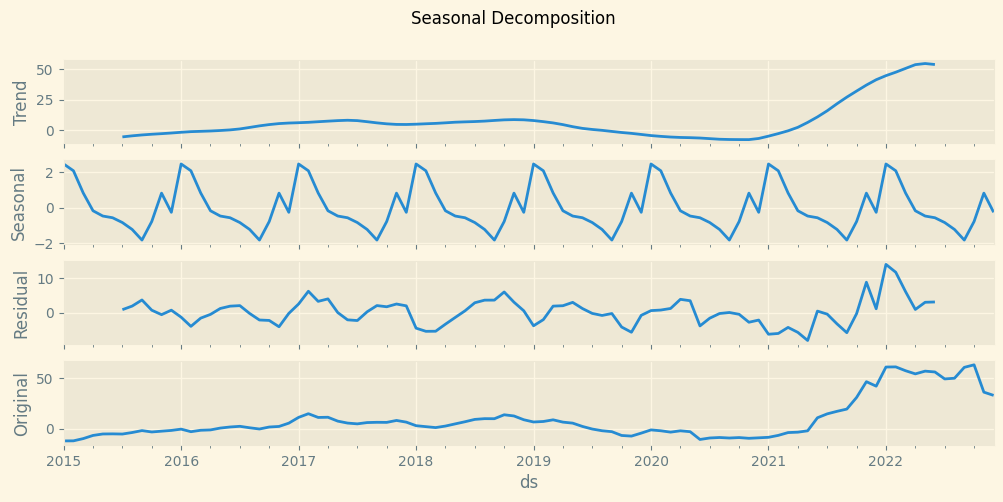

In [9]:
# 2. Visualize target data
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('Energy Inflation Rates in Belgium')
    plt.grid(axis='y', alpha=0.5)
    plt.legend()
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(df['y'])

In [10]:
# 3. ADF statistical test
def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Used Lags: ', result[2])
    print('4. Used Observations: ', result[3])
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(df['y'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic:  -2.50165134115575
2. P-value:  0.11507305246481492
3. Used Lags:  12
4. Used Observations:  83
5. Critical Values:
	1%: -3.5117123057187376
	5%: -2.8970475206326833
	10%: -2.5857126912469153

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [23]:
# 4. Perform data transformation - NOTICE NEW ARGUMENT IN FUNCTION
# series: must be a pandas dataframe
def series_transformation(series, num_lags):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    
    # 1st plot - data after transformation
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')
    
    # 2nd plot - partial autocorrelation plot
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=num_lags, title='Autocorrelation')
    # plot 95% confidence intervals
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    
    # 3rd plot - partial autocorrelation plot
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=num_lags, title='Partial Autocorrelation')
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    plt.show()
    
    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return

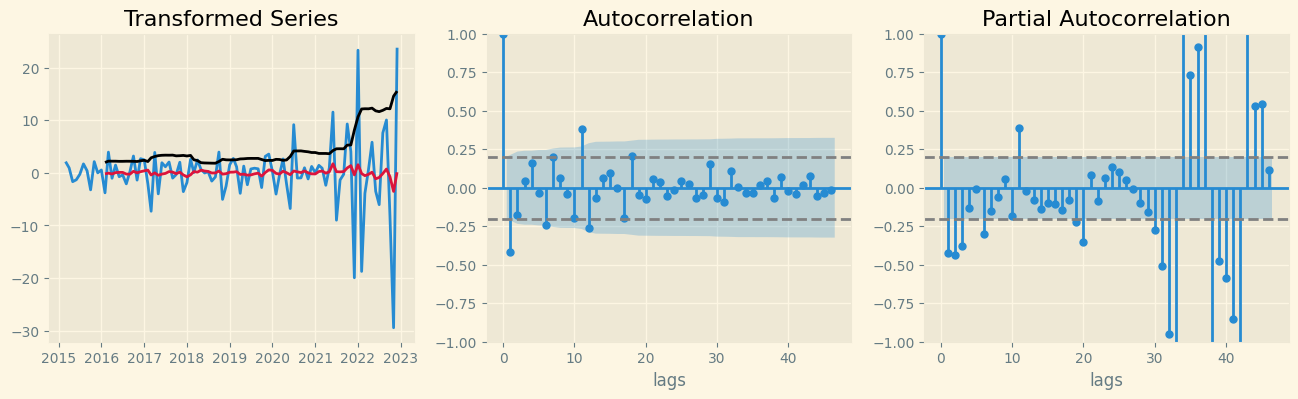

P-value = 0.768761, the series is likely non-stationary.


In [24]:
# second difference
series_transformation(df.diff().diff(), num_lags=46)

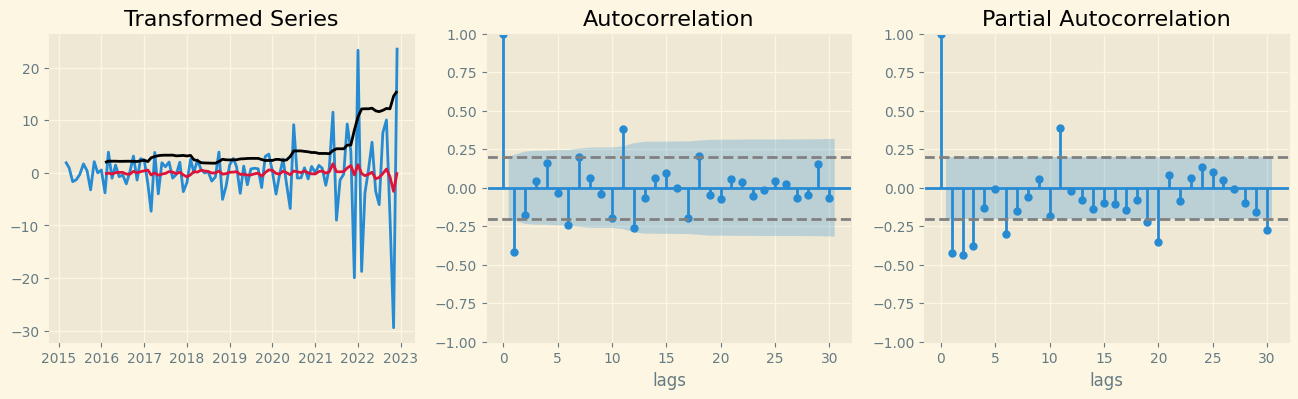

P-value = 0.768761, the series is likely non-stationary.


In [14]:
# new number of lags
series_transformation(df.diff().diff(), num_lags=30)

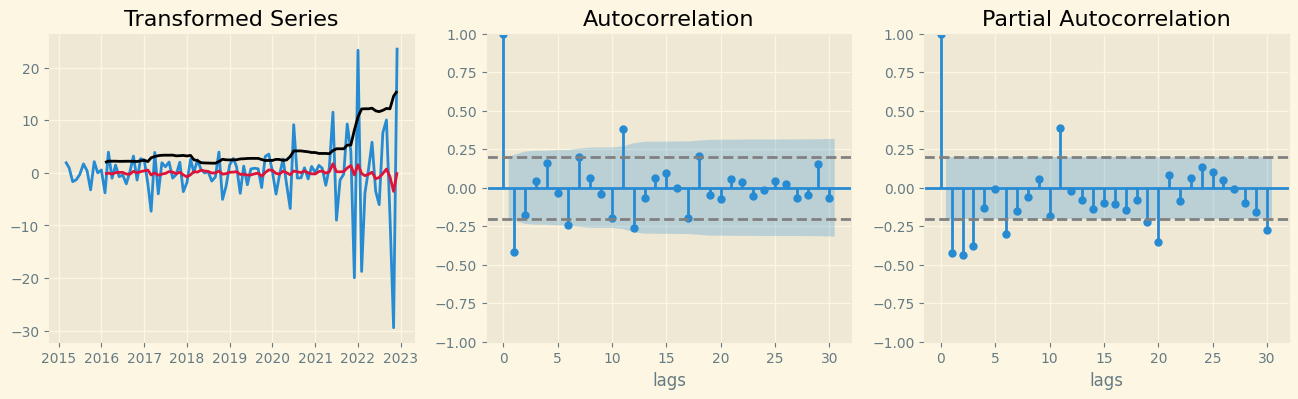

P-value = 0.768761, the series is likely non-stationary.


In [27]:
# new number of lags
series_transformation(df.diff().diff(), num_lags=30)

In [28]:
# 5. Find best orders and evaluate each combination for SARIMAX model
def find_optimal_orders(series, verbose=True):
    # filter out harmless warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    ######### list of possible combinations
    order_list = []
    for p in range(0, 2):
            for d in range(0, 2):
                for q in range(0, 2):
                    order_list.append((p, d, q))
    
    ######### initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(trend_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal, freq=None, exog=None,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except:
                print('Error while fitting model')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))

In [29]:
# display results
find_optimal_orders(df['y'], verbose=True)

Expected Fits: 64
========== SARIMAX Results ==========

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44250D+00    |proj g|=  3.32584D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   1.141D-06   4.442D+00
  F =   4.4424888980678965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 854.957868,	BIC = 857.511745
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.40587D+00    |proj g|=  9.87968D-02

At iterate   10    f=  3.37022D+00    |proj g|=  3.56042D-01

At iterate   15    f=  3.36543D+00    |proj g|=  3.81454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     26      1     0     0   1.461D-07   3.365D+00
  F =   3.3654281787820710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
8. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 652.162210,	BIC = 658.950250
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13452D+00    |proj g|=  4.77125D-01

At iterate    5    f=  3.04018D+00    |proj g|=  3.57571D-02

At iterate   10    f=  2.94198D+00    |proj g|=  8.89400D-02

At iterate   15    f=  2.92730D+00    |proj g|=  1.22520D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     26      1     0     0   1.237D-07   2.927D+00
  F =   2.9272187932766385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
12. SARIMAX(0, 0, 1)(0, 1, 1)[12],	AIC = 568.026008,	

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   2.627D-05   3.343D+00
  F =   3.3431848327417732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
14. SARIMAX(0, 0, 1)(1, 0, 1)[12],	AIC = 649.891488,	BIC = 659.518365
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22766D+00    |proj g|=  4.79473D-01

At iterate    5    f=  3.12273D+00    |proj g|=  2.08383D-01
  ys=-1.117E-02  -gs= 2.439E-03 BFGS update SKIPPED

At iterat


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-5.834E-03  -gs= 3.582E-03 BFGS update SKIPPED

At iterate    5    f=  3.03936D+00    |proj g|=  5.75152D-02

At iterate   10    f=  3.03165D+00    |proj g|=  1.59722D-01

At iterate   15    f=  2.93804D+00    |proj g|=  6.44408D-01

At iterate   20    f=  2.92729D+00    |proj g|=  5.31515D-02

At iterate   25    f=  2.92722D+00    |proj g|=  3.94278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     43      1     1     0   2.183D-04   2.927D+00
  F =   2.9272185826744628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
16. SARIMAX(0, 0, 1)(1, 1, 1)[12],	AIC = 570.025968,	BIC = 57

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


17. SARIMAX(0, 1, 0)(0, 0, 0)[12],	AIC = 566.569420,	BIC = 569.112714
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58279D+00    |proj g|=  5.10725D-02

At iterate    5    f=  2.53797D+00    |proj g|=  8.17037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   1.452D-08   2.538D+00
  F =   2.5379663172366080     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
18. SARIMAX(0, 1, 0)(0, 0, 1)[12],	AIC = 491.289533,	BIC = 496

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


29. SARIMAX(0, 1, 1)(1, 0, 0)[12],	AIC = 497.129220,	BIC = 504.385742
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50525D+00    |proj g|=  6.80268D-02

At iterate    5    f=  2.48600D+00    |proj g|=  6.99577D-03

At iterate   10    f=  2.48562D+00    |proj g|=  9.50662D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   9.507D-07   2.486D+00
  F =   2.4856197023930462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   9.605D-05   2.964D+00
  F =   2.9643486071546161     

ABNORMAL_TERMINATION_IN_LNSRCH                              
33. SARIMAX(1, 0, 0)(0, 0, 0)[12],	AIC = 573.154933,	BIC = 578.262686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01873D+00    |proj g|=  2.47979D-01

At iterate    5    f=  2.83714D+00    |proj g|=  3.64363D-02

At iterate   10    f=  2.74880D+00    |proj g|=  8.66016D-02

At iterate   15    f=  2.69781D+00    |proj g|=  1.10319D-01

At iterate   20    f=  2.67393D+00    |proj g|=  9.97083D-02

At iterate   25    f=  2.66365D+00    |

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.37354D+00    |proj g|=  9.49516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   5.528D-06   2.373D+00
  F =   2.3734734068104362     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
36. SARIMAX(1, 0, 0)(0, 1, 1)[12],	AIC = 461.706894,	BIC = 468.494934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88067D+00    |proj g|=  5.05749D-01

At iterate    5    f=  2.57081D+00    |proj g|=  1.81905D-02


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.92706D+00    |proj g|=  2.91551D-03

At iterate   10    f=  2.92701D+00    |proj g|=  4.58842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   1.124D-05   2.927D+00
  F =   2.9270072406465597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
41. SARIMAX(1, 0, 1)(0, 0, 0)[12],	AIC = 567.985390,	BIC = 575.615275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98180D+00    |proj g|=  2.47891D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85628D+00    |proj g|=  4.72826D-01

At iterate    5    f=  2.56223D+00    |proj g|=  5.50904D-02

At iterate   10    f=  2.55928D+00    |proj g|=  1.18078D-01

At iterate   15    f=  2.55708D+00    |proj g|=  6.62514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   5.372D-06   2.557D+00
  F =   2.5570820390874140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
45. SARI

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.33576D+00    |proj g|=  6.48417D-02

At iterate   10    f=  2.29106D+00    |proj g|=  8.88909D-02

At iterate   15    f=  2.28557D+00    |proj g|=  7.67783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     20      1     0     0   1.515D-05   2.286D+00
  F =   2.2855657357034445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
48. SARIMAX(1, 0, 1)(1, 1, 1)[12],	AIC = 448.828621,	BIC = 460.071097
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53328D+00    |proj g|=  2.98410D-02

At iterate    5    f=  2.53153D+00    |proj g|=  7.03114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   9.189D-07   2.532D+00
  F =   2.5315266098620537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
53. SARIMAX(1, 1, 0)(1, 0, 0)[12],	AIC = 492.053109,	BIC = 499.273267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.90187D+00    |proj g|=  7.90660D-03

At iterate   10    f=  2.89327D+00    |proj g|=  2.65731D-02
  ys=-2.466E-03  -gs= 2.045E-04 BFGS update SKIPPED

At iterate   15    f=  2.89281D+00    |proj g|=  3.46995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     28      1     1     0   2.391D-05   2.893D+00
  F =   2.8928114379272039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
57. SARIMAX(1, 1, 1)(0, 0, 0)[12],	AIC = 561.419796,	BIC = 569.017595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


62. SARIMAX(1, 1, 1)(1, 0, 1)[12],	AIC = 485.578476,	BIC = 497.550722
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44564D+00    |proj g|=  3.34155D-01

At iterate    5    f=  2.34804D+00    |proj g|=  8.11703D-03

At iterate   10    f=  2.34693D+00    |proj g|=  6.61325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   5.377D-06   2.347D+00
  F =   2.3469248275078507     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.



At iterate   15    f=  2.25037D+00    |proj g|=  1.12213D-02

At iterate   20    f=  2.25032D+00    |proj g|=  2.12928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   5.057D-06   2.250D+00
  F =   2.2503199521370991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
64. SARIMAX(1, 1, 1)(1, 1, 1)[12],	AIC = 442.061431,	BIC = 453.231963

Best order: (0, 1, 1)(1, 1, 1)[12] with AIC = 440.290876 at line 32


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33924D+00    |proj g|=  9.91727D-02

At iterate    5    f=  2.25976D+00    |proj g|=  6.88600D-02

At iterate   10    f=  2.25153D+00    |proj g|=  1.52740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   2.532D-06   2.252D+00
  F =   2.2515149793715898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


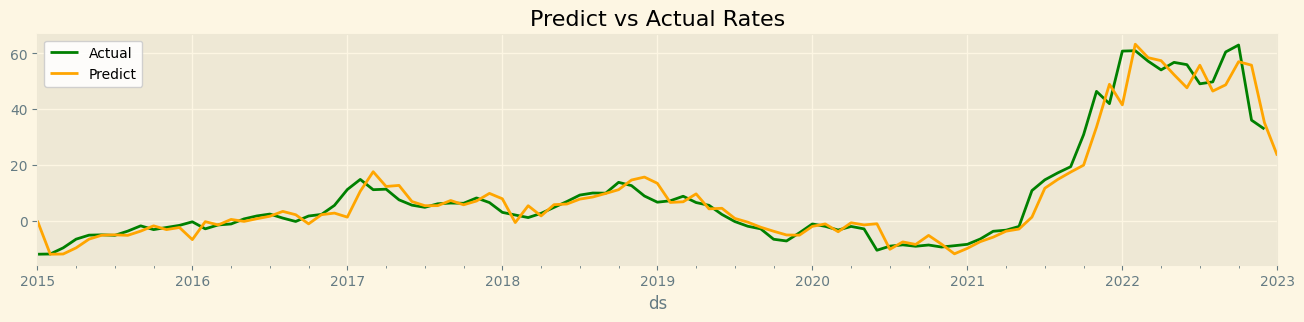

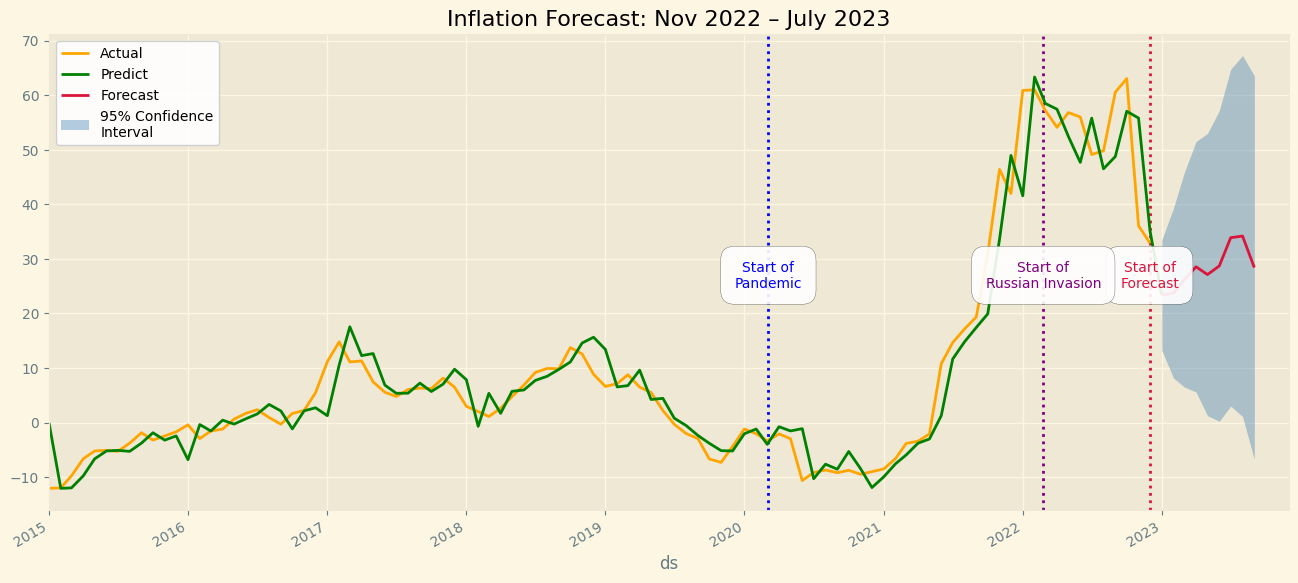

,Forecast [%]
2023-01-01,23.4
2023-02-01,23.8
2023-03-01,26.2
2023-04-01,28.6
2023-05-01,27.1
2023-06-01,28.7
2023-07-01,33.9
2023-08-01,34.2
2023-09-01,28.4


In [30]:
# SARIMA model visualization
def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='MS', exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False).rename('Predict')

    # forecast and confidence intervals 95%
    conf_int = model_fit.get_forecast(steps=9).summary_frame()
    
    # extract index list
    def index_list():
        conf_interval = conf_int.reset_index()
        return conf_interval['index'].to_list()

    indx_list = index_list()
    
    # 1st plot - actual vs predict rates
    series.plot(legend=True, label='Actual', figsize=(16, 3), color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Predict vs Actual Rates')
    plt.legend(facecolor='white', framealpha=0.9)
    plt.show()
    
    # list of events to plot
    event_list = [(pd.to_datetime('2020-03-04'), 'Start of\nPandemic', 'blue'),
                  (pd.to_datetime('2022-11-30'), 'Start of\nForecast', 'crimson'),
                  (pd.to_datetime('2022-02-24'), 'Start of\nRussian Invasion', 'purple')]
    
    # plot events
    for date_point, label, clr in event_list:
        plt.axvline(x=date_point, color=clr, linestyle=':')
        plt.text(x=date_point, y=27, s=label, horizontalalignment='center', verticalalignment='center',
                 color=clr, bbox=dict(facecolor='white', alpha=0.9, boxstyle='round, pad=1', linewidth=0.2))

    # 2nd plot - forecasting results
    series.plot(legend=True, label='Actual', figsize=(16, 7), color='orange')
    yhat.plot(legend=True, color='green')
    conf_int['mean'].plot(legend=True, label='Forecast', color='crimson')
    plt.fill_between(x=indx_list, y1=conf_int['mean_ci_upper'], y2=conf_int['mean_ci_lower'], color='steelblue',
                     alpha=0.4, label='95% Confidence\nInterval', linewidth=0)                
    plt.xlim(['2015', '2023-12'])
    plt.title('Inflation Forecast: Nov 2022 – July 2023')
    plt.legend(loc='upper left', facecolor='white', framealpha=0.9)
    plt.show()
    
    # display forecasted rates
    return pd.DataFrame(round(conf_int['mean'], 1)).rename({'mean': 'Forecast [%]'}, axis=1)

# plot SARIMA results
forecast_SARIMA(series=df['y'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33924D+00    |proj g|=  9.91727D-02

At iterate    5    f=  2.25976D+00    |proj g|=  6.88600D-02

At iterate   10    f=  2.25153D+00    |proj g|=  1.52740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   2.532D-06   2.252D+00
  F =   2.2515149793715898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


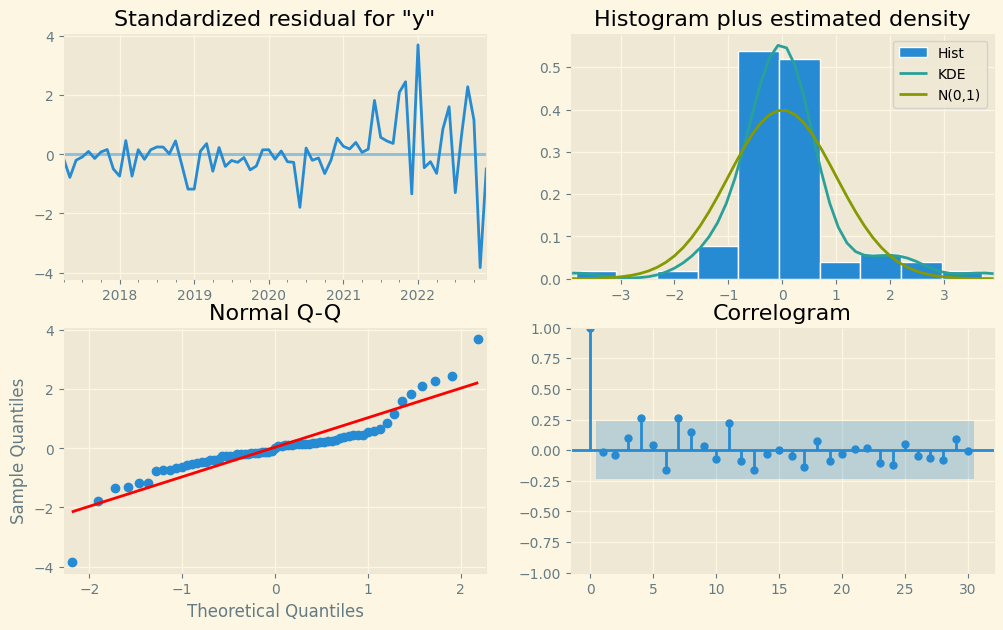

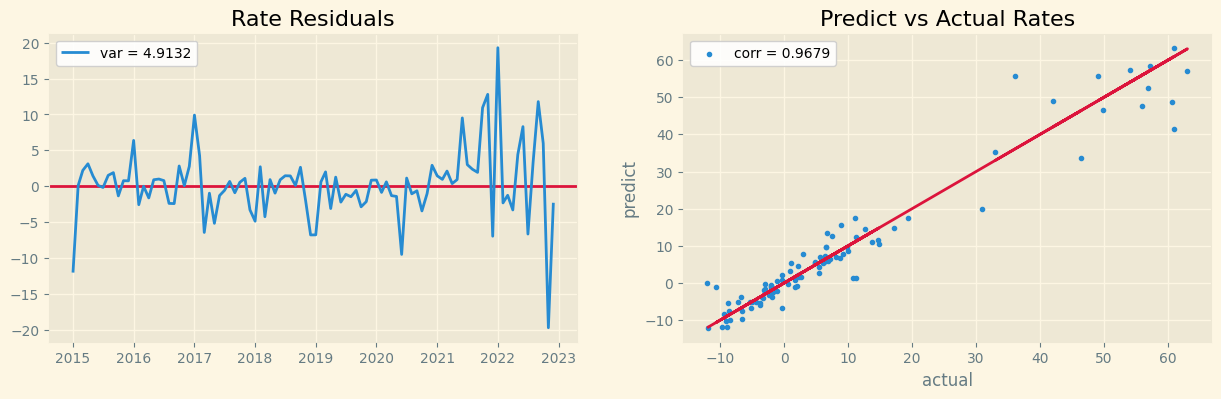

Metric,AIC,BIC,HQIC,RMSE,MAE,MAPE
,440.290876,449.227302,443.836255,4.917872,3.179787,0.720669


In [31]:
# SARIMA model evaluation
def evaluate_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='MS', exog=None,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False).rename('Predict')
    
    ######### evaluation scores
    rmse = np.mean((series - yhat[:-1])**2)**0.5
    mae = np.mean(np.abs(series - yhat[:-1]))
    mape = np.mean(np.abs(series - yhat[:-1])/np.abs(series))
    var = np.std(model_fit.resid.values)
    corr = np.corrcoef(series, yhat[:-1])[0, 1]
    
    metric_list = ['AIC', 'BIC', 'HQIC', 'RMSE', 'MAE', 'MAPE']
    value_list = [model_fit.aic, model_fit.bic, model_fit.hqic, rmse, mae, mape]
 
    # 1st plot - diagnostics
    model_fit.plot_diagnostics(lags=30, figsize=(12, 7))
    plt.show()
    
    # 2nd plot - residuals
    fig = plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.axhline(0, color='crimson')
    plt.plot(model_fit.resid, label='var = {:.4f}'.format(var))
    plt.title('Rate Residuals')
    plt.legend(facecolor='white', framealpha=0.9)
    
    # 3rd plot - actual vs predict rates
    plt.subplot(1, 2, 2)
    plt.plot(df['y'], df['y'], color='crimson')
    plt.scatter(x=df['y'], y=yhat[:-1], marker='.', label='corr = {:.4f}'.format(corr))
    plt.title('Predict vs Actual Rates')
    plt.xlabel('actual')
    plt.ylabel('predict')
    plt.legend(facecolor='white', framealpha=0.9)
    plt.show()

    # display evaluation scores
    return pd.DataFrame(zip(metric_list, value_list), columns=['Metric', '']).set_index('Metric').T

# model evaluation
evaluate_SARIMA(series=df['y'],  order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))